## Testing Module 1 - Camera Calibration
#### Get the objpoints and imgpoints for all the calibration images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# Define the number of corners in the chessboard photos
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #plt.imshow(img)
        

## Common Module - Line Class

In [2]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        #current left_fitx
        self.left_fitx = None
        #current right_fitx
        self.right_fitx = None
        #current ploty
        self.ploty = None
        #Previous reasonable warp image
        self.pre_warp = None
        # The car Position
        self.car_position = None
        
        
detected_line = Line();

## Testing Module 2 - Distortion correction check
#### 1. Use objpoints and imgpoints to get calbration result
#### 2. Use calibration result to perform distortion correction and check the result
#### p.s. not all the images could find the corners

Text(0.5,1,'Undistorted Image')

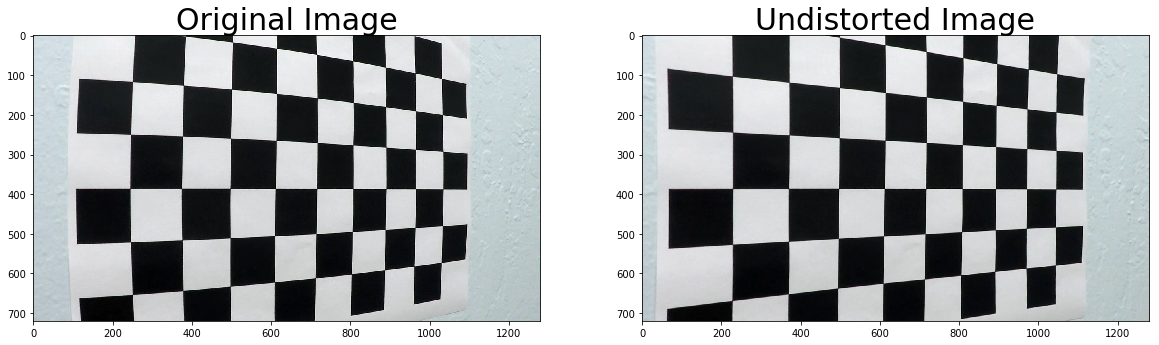

In [3]:
import pickle
import matplotlib.image as mpimg
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Take a image to perform distortion correctness
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/calibration_result/calibration5_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/camera_calibration_pickle.p", "wb" ) )

#print (mtx)
#print (dist)

# Visualize distortion corectness result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)



## Testing Module 3 - Check the result of Perspective Transformation
#### 1. Take the camera calibration result to find chessboard corners
#### 2. Define the source and destination area to perform perspective transformation
#### 3. Get the trasnform matrix and perform transofrmation and check the result
#### p.s. not all the images could find the corners

True
found corners= 54 img.shape[0]= 721 img.shape[1]= 1281
[[ 931.20581055  301.1946106 ]]
[[ 1233.37133789   325.66442871]]
[[ 1231.26794434   567.27679443]]
[[ 923.46240234  589.43206787]]


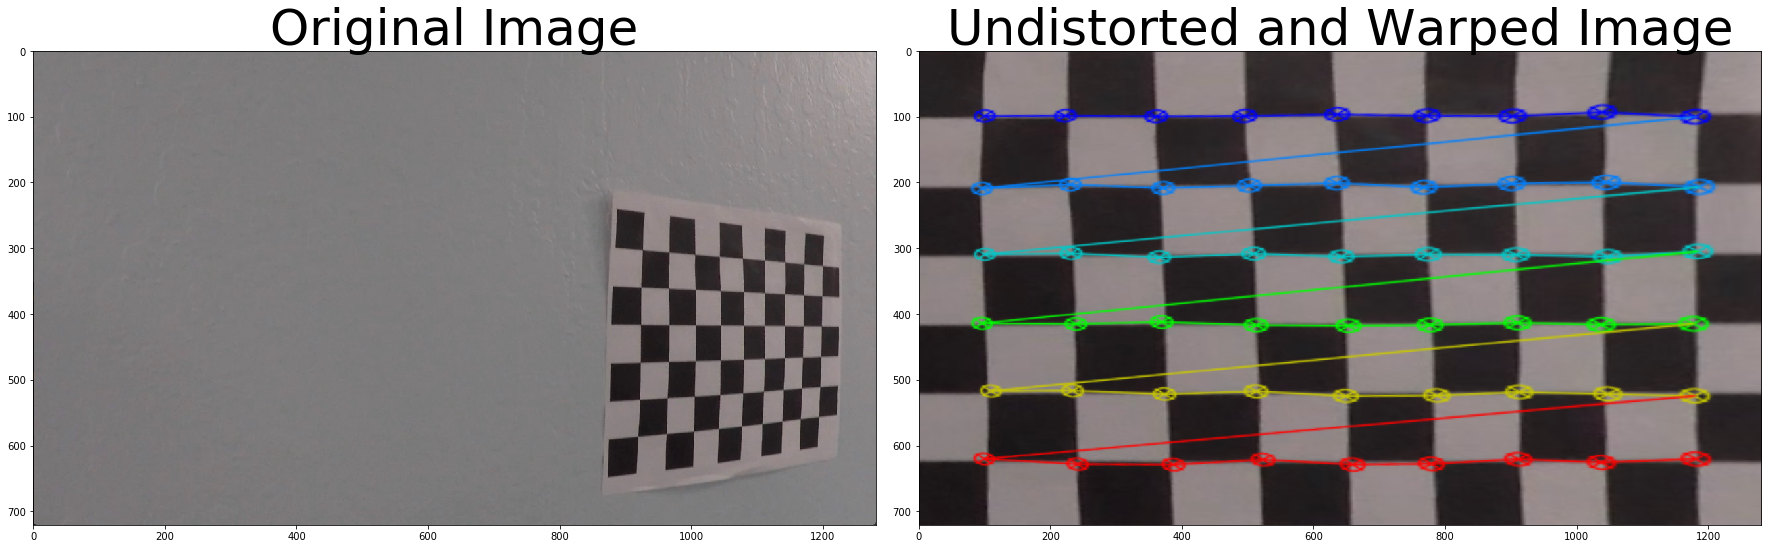

In [4]:
import matplotlib.image as mpimg

def corners_unwarp(img, nx, ny, mtx, dist):
    warped = None
    M = None
    
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # 2) Convert to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # 4) If corners found: 
    print (ret)
    if ret == True:
        # a) draw corners
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        print ("found corners=", len(corners), "img.shape[0]=", img.shape[0], 
            "img.shape[1]=", img.shape[1])
        print(corners[0])
        print(corners[nx-1])
        print(corners[-1])
        print(corners[-nx])
        
        # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
        src = np.float32([corners[0],corners[nx-1],corners[-1],corners[-nx]])
        
        # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
        dst = np.float32([[100, 100], [img.shape[1]-100, 100], 
            [img.shape[1]-100, img.shape[0]-100],[100, img.shape[0]-100]])
                          
        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        
        # e) use cv2.warpPerspective() to warp your image to a top-down view
        img_size = (img.shape[1], img.shape[0])
        warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M


img = cv2.imread('camera_cal/calibration15.jpg')
#print (img.shape)
#print (nx)
#print (ny)
#print (mtx)
#print (dist)

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Testing Module 4 - Apply the threshold of gradient magnitude and gradient driection
#### 1. Define the threshold of gradient of magnitude and driection
#### 2. Combine the images from 2 thresholds and plot it out

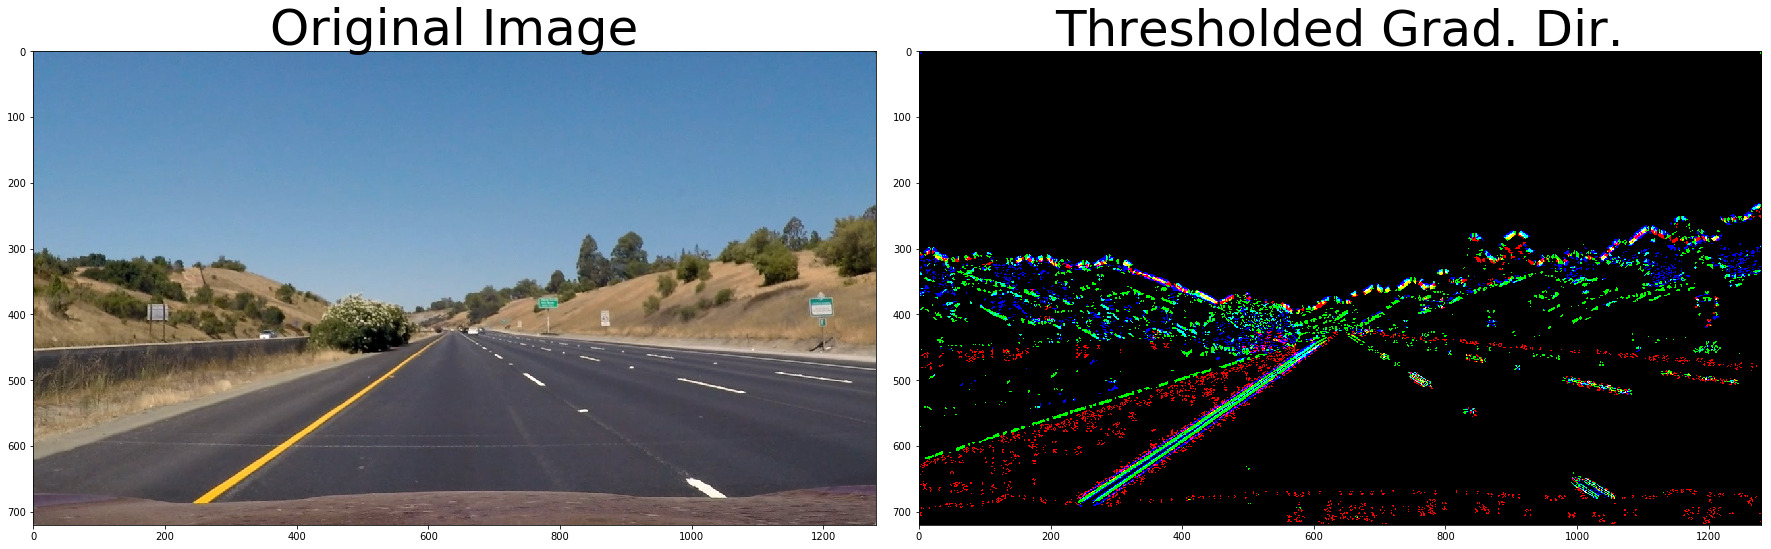

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # Apply threshold
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary


def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude ()
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Apply threshold
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return mag_binary


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    dir_gradient = np.arctan2(abs_sobely, abs_sobelx)
    
    # Apply threshold
    dir_binary = np.zeros_like(dir_gradient)
    dir_binary[(dir_gradient >= thresh[0]) & (dir_gradient <= thresh[1])] = 1
    
    return dir_binary


# Choose a Sobel kernel size
ksize = 13 # Choose a larger odd number to smooth gradient measurements

# Read in an image and grayscale it
img = mpimg.imread('test_images/straight_lines1.jpg')
#img = cv2.imread('test_images/test1.jpg')


# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(100, 255))
mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#combined[(mag_binary == 1) & (dir_binary == 1)] = 1
#combined[ (gradx == 1) & (grady == 1)] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined)
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Testing Module 5 - Apply the color threshold on HLS and the Gradient threshold
### 1. Use L channel and apply x gradient threshold (green)
### 2. Use color threshold on S channel (blue)
### 3. Combine 2 thresholds and check the result

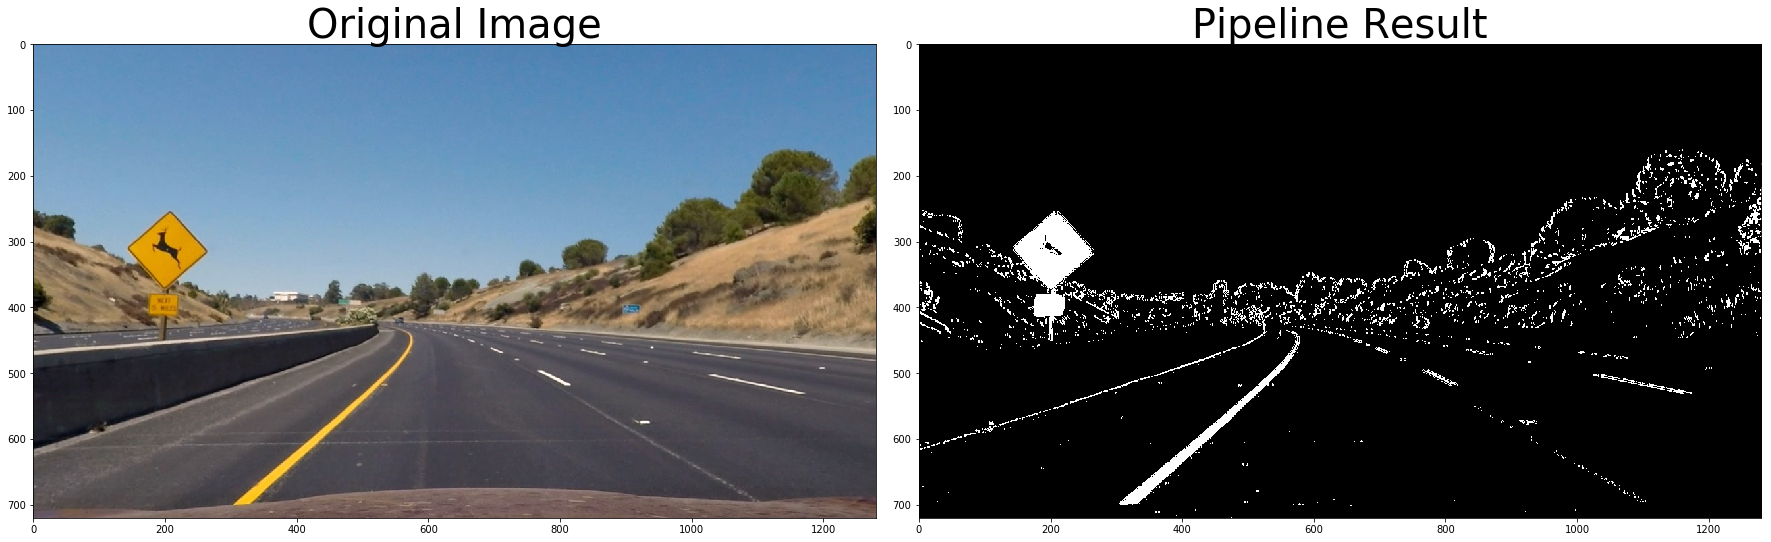

In [6]:
def color_grd_threshold_check(img, s_thresh=(150, 255), sx_thresh=(30, 100)):
    img = np.copy(img)
    # Convert to HLS color space and keep the L and S channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the x derivative on L channel
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return color_binary, combined_binary


img = mpimg.imread('test_images/test2.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
color_result, combined_result = color_grd_threshold_check(dst)

#cv2.imwrite('output_images/straight_lines2_output.jpg',combined_result)


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(dst)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(combined_result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Testing Module 6 - Perspective Transform
### Straight Line
### Curving Line

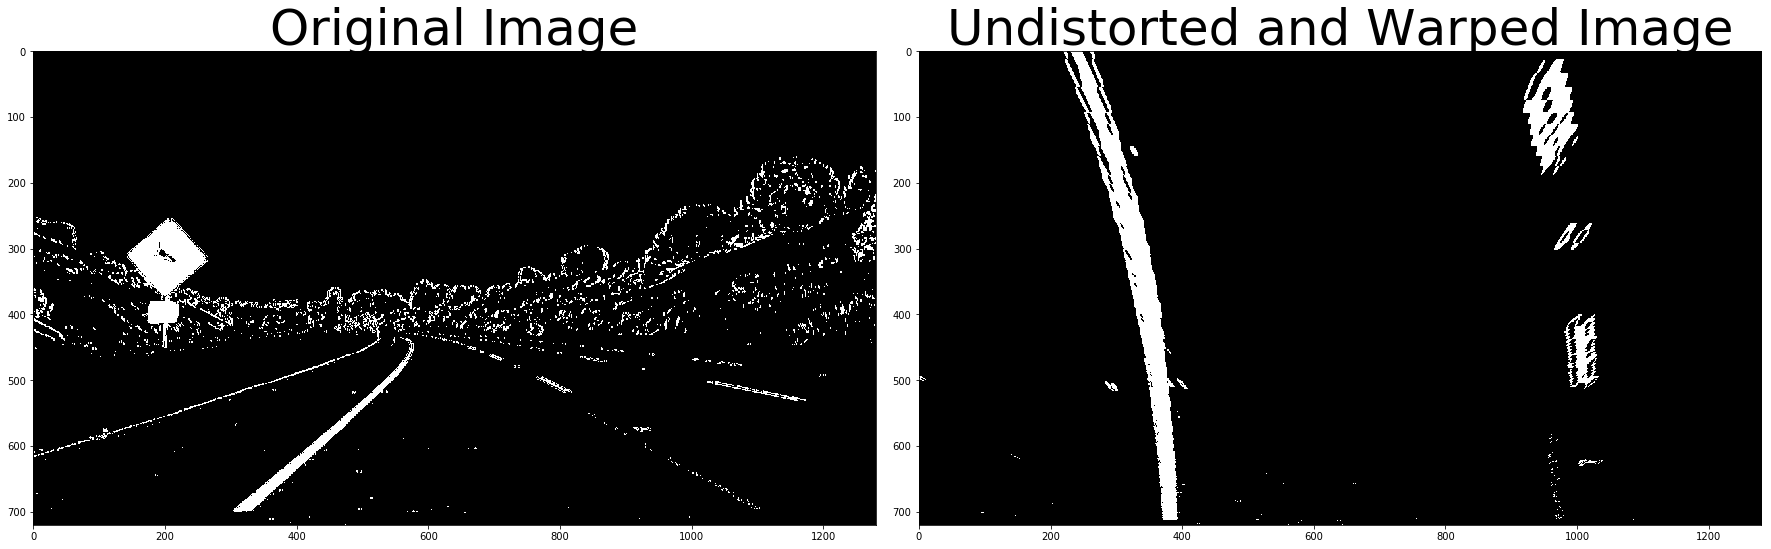

In [7]:
def perp_transform(img):
    img_size = (img.shape[1], img.shape[0])
    #print ("img size", img_size)
    
    src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

top_down, perspective_M, Minv = perp_transform(combined_result)

# img_size = (dst.shape[1], top_down.shape[0])
# src_pts = np.int32(
#     [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
#     [((img_size[0] / 6) - 10), img_size[1]],
#     [(img_size[0] * 5 / 6) + 60, img_size[1]],
#     [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    
# dst_pts = np.int32(
#     [[(img_size[0] / 4), 0],
#     [(img_size[0] / 4), img_size[1]],
#     [(img_size[0] * 3 / 4), img_size[1]],
#     [(img_size[0] * 3 / 4), 0]])
    
# src_pts = src.reshape((-1, 1, 2)) 
# #dst_pts = dst.reshape((-1, 1, 2))
# thickness = 2
# isClosed = True
# color=[255, 0, 0]

# #print ("src_pts", src_pts)
# #print ("dst_pts", dst_pts)
    
# dst = cv2.polylines(dst, [src_pts], isClosed, color, thickness) 



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_result, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Testing  Module 7 - Peaks in Histogram

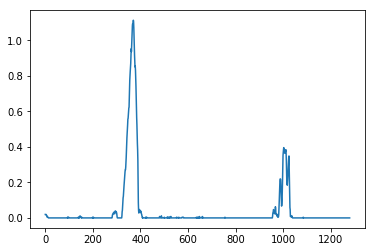

In [8]:
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
nor_img = top_down/255

def hist(img):
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

histogram = hist(nor_img)

# Visualize the resulting histogram
plt.plot(histogram)

## Testing Module 8 - Sliding Window and Fit a Polynominal

left_fit :  [ -2.36712401e-04   3.63106687e-01   2.40649184e+02]
right_fit :  [ -1.41123993e-04   1.92041425e-01   9.43439958e+02]


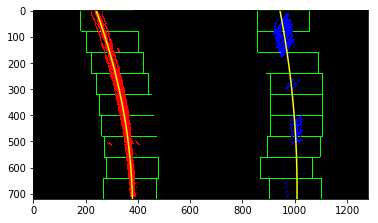

In [9]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #print (nonzero)
    #print ("np.shape(nonzero)", np.shape(nonzero))
    #print ("np.shape(nonzeroy)", np.shape(nonzeroy))
    #print ("np.shape(nonzerox)", np.shape(nonzerox))
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        # Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        
        # If you found > minpix pixels, recenter next window ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        #print ("np.shape(left_lane_inds)", np.shape(left_lane_inds))
        #print ("np.shape(right_lane_inds)", np.shape(right_lane_inds))
        
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #print ("np.shape(leftx)", np.shape(leftx))
    #print ("np.shape(lefty)", np.shape(lefty))
    #print ("np.shape(rightx)", np.shape(rightx))

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    leftx_bottom = left_fitx[len(left_fitx) - 1]
    rightx_bottom = right_fitx[len(right_fitx) - 1]
    car_position = (leftx_bottom+rightx_bottom)/2
        
    detected_line.left_fitx = left_fitx
    detected_line.right_fitx = right_fitx
    detected_line.ploty = ploty
    detected_line.car_position = car_position
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines    
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit



out_img, left_fit, right_fit = fit_polynomial(top_down)

print ("left_fit : ", left_fit)
print ("right_fit : ", right_fit)
    
plt.imshow(out_img)

## Testing Module 9 - Find the lane line from prior

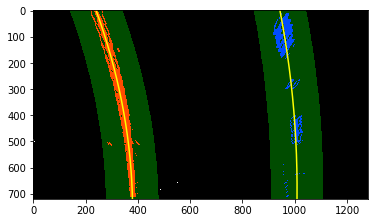

In [10]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calculate both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
                    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
                    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    leftx_bottom = left_fitx[len(left_fitx) - 1]
    rightx_bottom = right_fitx[len(right_fitx) - 1]
    car_position = (leftx_bottom+rightx_bottom)/2
    
    detected_line.left_fitx = left_fitx
    detected_line.right_fitx = right_fitx
    detected_line.ploty = ploty
    detected_line.car_position = car_position
    
    #print ("np.shape(left_fitx)", np.shape(left_fitx))
    #print ("np.shape(right_fitx)", np.shape(right_fitx))
    #print ("np.shape(ploty)", np.shape(ploty)) 
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result
           
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!

#left_fit = np.array([3.85472140e-05, 1.68934035e-02,2.98777056e+02])
#right_fit = np.array([-5.58285877e-06, -9.60232078e-02, 1.01918064e+03])

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(top_down)

# View your output
plt.imshow(result)

## Testing Module 10 - draw lane area

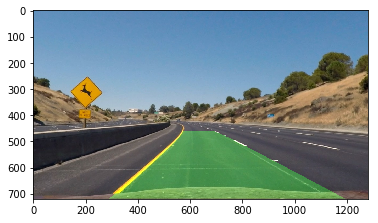

In [11]:
# Create an image to draw the lines on
def result_prep(top_down): 
    warp_zero = np.zeros_like(top_down).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([detected_line.left_fitx, detected_line.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([detected_line.right_fitx, detected_line.ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    # Backup current resaonable warp image
    detected_line.pre_warp = newwarp
    
    return newwarp

# Combine the result with the original image
undist = cv2.undistort(img, mtx, dist, None, mtx)
newwarp = result_prep(top_down)

result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

## Testing Module 11 - Calculate the curvature

In [12]:
def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(detected_line.ploty)
    
    # The calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


def convert_pixel_to_real(ym_per_pix, xm_per_pix):
    
    #print ("np.shape(left_fitx)", np.shape(left_fitx))
    #print ("np.shape(right_fitx)", np.shape(right_fitx))
    #print ("np.shape(ploty)", np.shape(ploty))
    
    left_fit_cr = np.polyfit(detected_line.ploty*ym_per_pix, detected_line.left_fitx*xm_per_pix, 2) 
    right_fit_cr = np.polyfit(detected_line.ploty*ym_per_pix, detected_line.right_fitx*xm_per_pix, 2)
    
    return left_fit_cr, right_fit_cr
    
def measure_curvature_real():
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Feed in the data stored in detected_line 
    left_fit_cr, right_fit_cr = convert_pixel_to_real(ym_per_pix, xm_per_pix)
    
    #print ("left_fit_cr", left_fit_cr)
    #print ("right_fit_cr", right_fit_cr)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(detected_line.ploty)
    
    #Implement the calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    '''
    Calculate the vehicle position from center
    '''
    distance_from_center = abs(img.shape[1]/2 - detected_line.car_position) * xm_per_pix
    distance_from_center = str(round(distance_from_center, 2))
        
    return left_curverad, right_curverad, distance_from_center


###### Calculate the radius of curvature in pixels for both lane lines #####
#left_curverad, right_curverad = measure_curvature_pixels()
#print(left_curverad, right_curverad)


# Calculate the radius of curvature in meters for both lane lines
left_curverad_real, right_curverad_real, distance_from_center = measure_curvature_real()
print(left_curverad_real, 'm', right_curverad_real, 'm')
print ("distance from center", distance_from_center, 'm')



693.790317458 m 1163.70854812 m
distance from center 0.29 m


## Production Module - Build an image processing pipeline

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [14]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # Return the final output (image where line are is drawn)

    cpy_img = np.copy(image)
    
    #1. Perform distortion correction
    undist = cv2.undistort(cpy_img, mtx, dist, None, mtx)
    
    #2. Use L channel and apply x gradient threshold (green)
    #3. Use color threshold on S channel (blue)
    color_result, combined_result = color_grd_threshold_check(undist)
    
    #4. Perspective Transform
    top_down, perspective_M, Minv = perp_transform(combined_result)
    
    #5. use the detected pixels to fit into Polynominal and retrieve the coefficients of left and right lanes
    if detected_line.left_fitx == None or detected_line.right_fitx == None:
        out_img, left_fit, right_fit = fit_polynomial(top_down)
    #6. Search from prior if the lines detection was found 
    else:
        result = search_around_poly(top_down) 
        
    #7. Check that the new line detections makes sense in terms of expected curvature.
    left_curverad_real, right_curverad_real, distance_from_center = measure_curvature_real()
    
    if left_curverad_real < 100 or left_curverad_real > 10000 or right_curverad_real < 100 or right_curverad_real > 10000:
        #print("unreasonalble curvature : ", left_curverad_real, 'm', right_curverad_real, 'm')
        #bypass this frame, use the previous frame to draw the lane area
        newwarp = detected_line.pre_warp
    
    elif np.abs(left_curverad_real / right_curverad_real) > 1.5 or np.abs(left_curverad_real / right_curverad_real) < 0.5:
        #bypass this frame, use the previous frame to draw the lane area
        newwarp = detected_line.pre_warp
    else:
        newwarp = result_prep(top_down)
        
    avg_curvature = (left_curverad_real + right_curverad_real) / 2
    avg_curvature = str(round(avg_curvature, 2))
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10,30)
    bottomLeftCornerOfText2 = (10,80)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2
        
    #8. Produce the final result
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    str_curvature = 'curvature: ' + avg_curvature + ' m'
    str_d_from_center = 'distance from lane center: ' + distance_from_center + ' m'
    
    cv2.putText(result, str_curvature, 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    cv2.putText(result, str_d_from_center, 
    bottomLeftCornerOfText2, 
    font, 
    fontScale,
    fontColor,
    lineType)

    return result

[MoviePy] >>>> Building video test_video_output/project_video.mp4
[MoviePy] Writing video test_video_output/project_video.mp4


100%|█████████▉| 1260/1261 [03:55<00:00,  5.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/project_video.mp4 

CPU times: user 1min 46s, sys: 2.96 s, total: 1min 49s
Wall time: 3min 58s


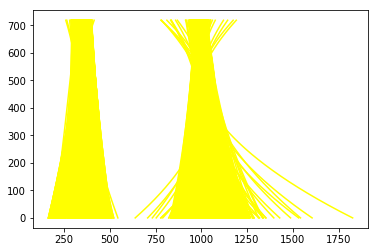

In [15]:
project_output = 'test_video_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

In [ ]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(project_output))